In [27]:
# Import required libraries
import pandas as pd
import numpy as np
import torch
from model_builder import create_dnn_model, create_cnn_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from model_builder import SimpleDNN, SimpleCNN
import torch.nn.functional as F
from plotter import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

input_csv = "patches_with_majority_pathology.csv"
df = pd.read_csv(input_csv)


# Settings: 
do_pca = True
pca_components = 10
pca_dimensions = [0.8, 0.85, 0.9, 0.95]
epochs = 1
output_base_path = "models/"
output_path_extra_desciptor = "" # leave empyt if not needed; 
ebbeding_dim = 1536

Get pathology training data

In [28]:
from sklearn.decomposition import PCA

feature_cols = [str(i) for i in range(1536)]
X = df[feature_cols].values.astype(np.float32)
y = LabelEncoder().fit_transform(df['label'].values).astype(np.int64)
labelEncoder = LabelEncoder().fit(df['label'].values)

#without pca
dnn_output_path = "models/dnn_pathology_model.pth"
df = pd.read_csv(input_csv)
X_pcaList = []
for d in pca_dimensions:
# Initialize PCA with the specified number of components
    pca = PCA(n_components=pca_components)
    X_pcaList.append(pca.fit_transform(X))
    

# The new data X_pca has reduced dimensions
#print(f"Original data shape: {X.shape}")
# print(f"Data shape after PCA: {X_pca.shape}")

# # You can also see how much variance is explained by each component
# print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
# print(f"Total variance explained by {pca_components} components: {np.sum(pca.explained_variance_ratio_):.2f}")


Train DNN model

In [29]:
dnn_list = []
acc_list = []
if do_pca:
    print("Using PCA for dimensionality reduction...")
    for i, X_pca in enumerate(X_pcaList):
        print(f"Shape of PCA transformed data: {X_pca.shape}")
        X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
        dnn_output_path = f"{output_base_path}/dnn_pathology_model_pca_{pca_components}.pth"
        model,acc = create_dnn_model(X_train, X_test, y_train, y_test, dnn_output_path, labelEncoder, inputDim=pca_components, epochs=epochs)
        dnn_list.append(model)
        acc_list.append(acc)
        print(f"Training set size: {X_train.shape[0]}")
        print(f"Testing set size: {X_test.shape[0]}")
        print("")
# Once without PCA        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
dnn_output_path = f"{output_base_path}/dnn_pathology_model_without_pca.pth"
dnn_without_pca, acc_without_pca = create_dnn_model(X_train, X_test, y_train, y_test, dnn_output_path, labelEncoder, inputDim=ebbeding_dim, epochs=epochs)
print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Using PCA for dimensionality reduction...
Shape of PCA transformed data: (5518, 10)
DNN: Epoch 1 completed. Average Loss: 0.4403
DNN Accuracy: 0.893
Training set size: 4414
Testing set size: 1104

Shape of PCA transformed data: (5518, 10)
DNN: Epoch 1 completed. Average Loss: 0.4521
DNN Accuracy: 0.897
Training set size: 4414
Testing set size: 1104

Shape of PCA transformed data: (5518, 10)
DNN: Epoch 1 completed. Average Loss: 0.4525
DNN Accuracy: 0.884
Training set size: 4414
Testing set size: 1104

Shape of PCA transformed data: (5518, 10)
DNN: Epoch 1 completed. Average Loss: 0.4421
DNN Accuracy: 0.895
Training set size: 4414
Testing set size: 1104

DNN: Epoch 1 completed. Average Loss: 0.3966
DNN Accuracy: 0.928
Training set size: 4414
Testing set size: 1104


Train CNN model

In [30]:
cnn_output_path = "models/cnn_pathology_model.pth" # not needed anymore since we dont save the models externally
create_cnn_model(X_train, X_test, y_train, y_test, cnn_output_path, labelEncoder,epochs=epochs)

CNN: Epoch 1 completed. Average Loss: 0.4692


~~Load trained models and perform dummy predictions~~ We dont extrnaly save the models


In [31]:
# # Load DNN model
# if do_pca:
#     input_dim = pca_components
# else:
#     input_dim = 1536
# dnn_list = []

# #for each pca_components in pca_dimensions load all models
# for pca_components in pca_dimensions:
#     dnn_output_path = f"{output_base_path}dnn_pathology_model_pca_{pca_components}.pth"
#     dnn_model = SimpleDNN(input_dim, len(np.unique(y_train)))
#     checkpoint_dnn = torch.load(dnn_output_path)
#     dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
#     dnn_list.append(dnn_model)
#     dnn_model.eval()


    
# # dnn_model = SimpleDNN(input_dim, len(np.unique(y_train)))
# # checkpoint_dnn = torch.load(dnn_output_path)
# # dnn_model.load_state_dict(checkpoint_dnn.get("state_dict", checkpoint_dnn))
# # dnn_model.eval()


In [32]:

# # Load CNN model
# cnn_model = SimpleCNN(len(np.unique(y_train)))
# checkpoint_cnn = torch.load(cnn_output_path)
# cnn_model.load_state_dict(checkpoint_cnn.get("state_dict", checkpoint_cnn))
# cnn_model.eval()

In [33]:
# # Load saved label classes from the DNN model checkpoint
# checkpoint = torch.load(dnn_output_path)
# if "label_classes" in checkpoint:
#     original_labels = np.array(checkpoint["label_classes"])

# # One sample demo predictions of DNN model
# sample_input = torch.tensor(X_test[0]).unsqueeze(0)  # Add batch dimension
# dnn_output = dnn_model(sample_input)
# dnn_pred_enc = F.softmax(dnn_output, dim=1).argmax(dim=1).item()
# dnn_pred_label = original_labels[dnn_pred_enc]
# true_label = original_labels[y_test[0]]
# print(f"DNN model prediction: {dnn_pred_label} (encoded: {dnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")

# # One sample demo predictions of CNN model
# sample_input = torch.tensor(X_test[0]).unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
# #cnn_output = cnn_model(sample_input)
# #cnn_pred_enc = F.softmax(cnn_output, dim=1).argmax(dim=1).item()
# #cnn_pred_label = original_labels[cnn_pred_enc]
# #print(f"CNN model prediction: {cnn_pred_label} (encoded: {cnn_pred_enc}), True: {true_label} (encoded: {y_test[0]})")


In [34]:
print(df.columns)

Index(['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '1527', '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535',
       'label'],
      dtype='object', length=1539)


## Visualize Sample points

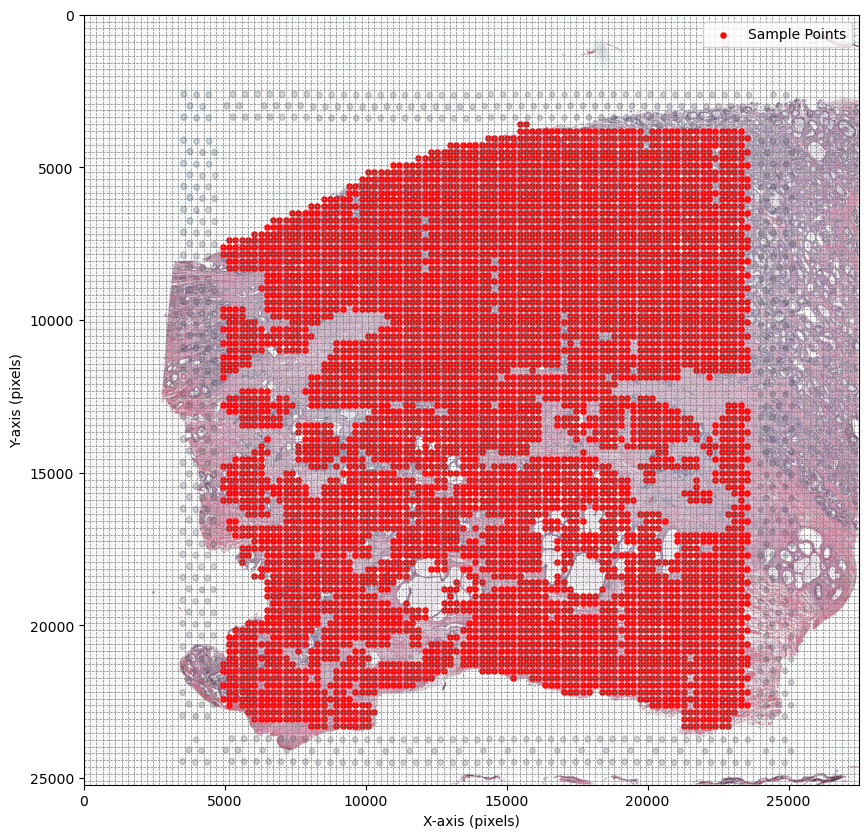

In [35]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples(image_path, df, 27482, 25219)



## Visualize Ground Truth Labels on Tissue Image

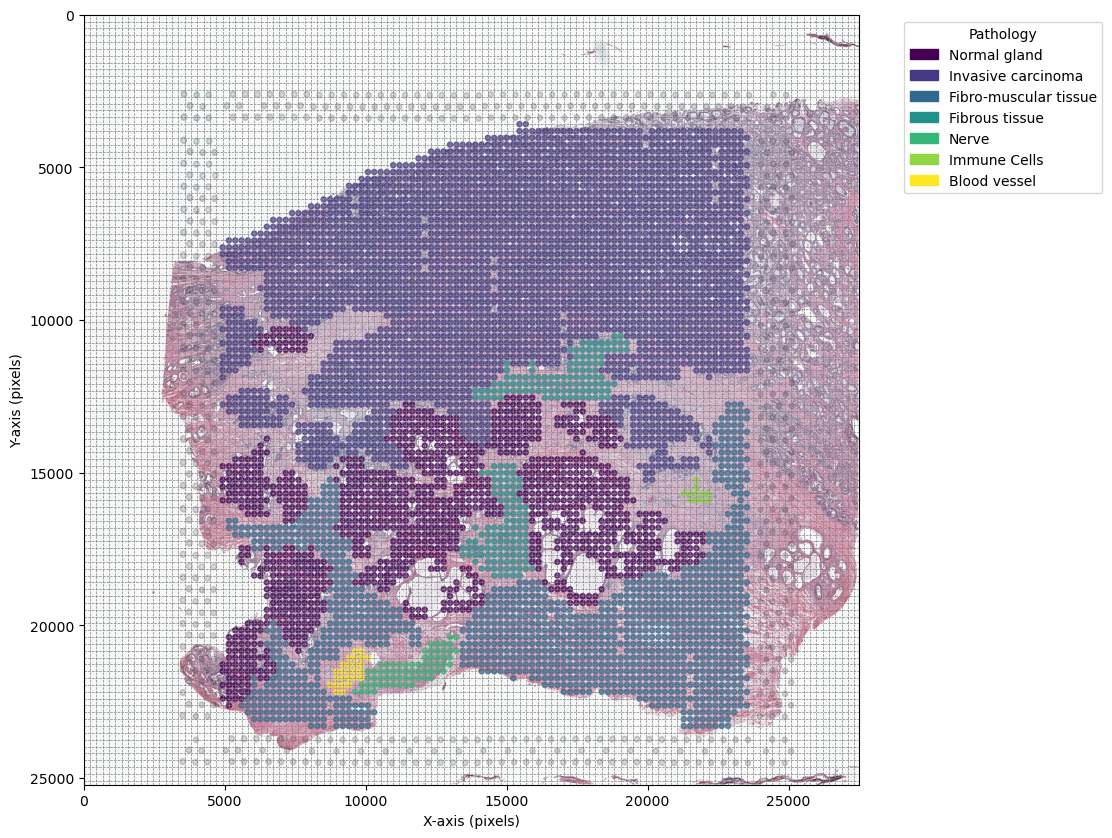

In [36]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df, 27482, 25219)


## Visualize predictions from DNN

In [50]:
original_labels = labelEncoder.classes_.tolist()

# Get predictions for all data
list_of_prediced_labels = []
X_tensor = torch.tensor(X_pca).float()

for i,dnn_model in enumerate(dnn_list):
    X_tensor = torch.tensor(X_pcaList[i]).float()
    with torch.no_grad():
        dnn_outputs_temp = dnn_model(X_tensor)
        temp = F.softmax(dnn_outputs_temp, dim=1).argmax(dim=1)
        # list comphehension of predicted labels
        list_of_prediced_labels = [original_labels[label] for label in temp.numpy()]
# Decode predictions


# # Create the new dataframe
df_predicted_dnn = df[['Patch_X', 'Patch_Y']].copy()
df_predicted_dnn['label'] = list_of_prediced_labels#predicted_labels

#print(df_predicted_dnn.head())

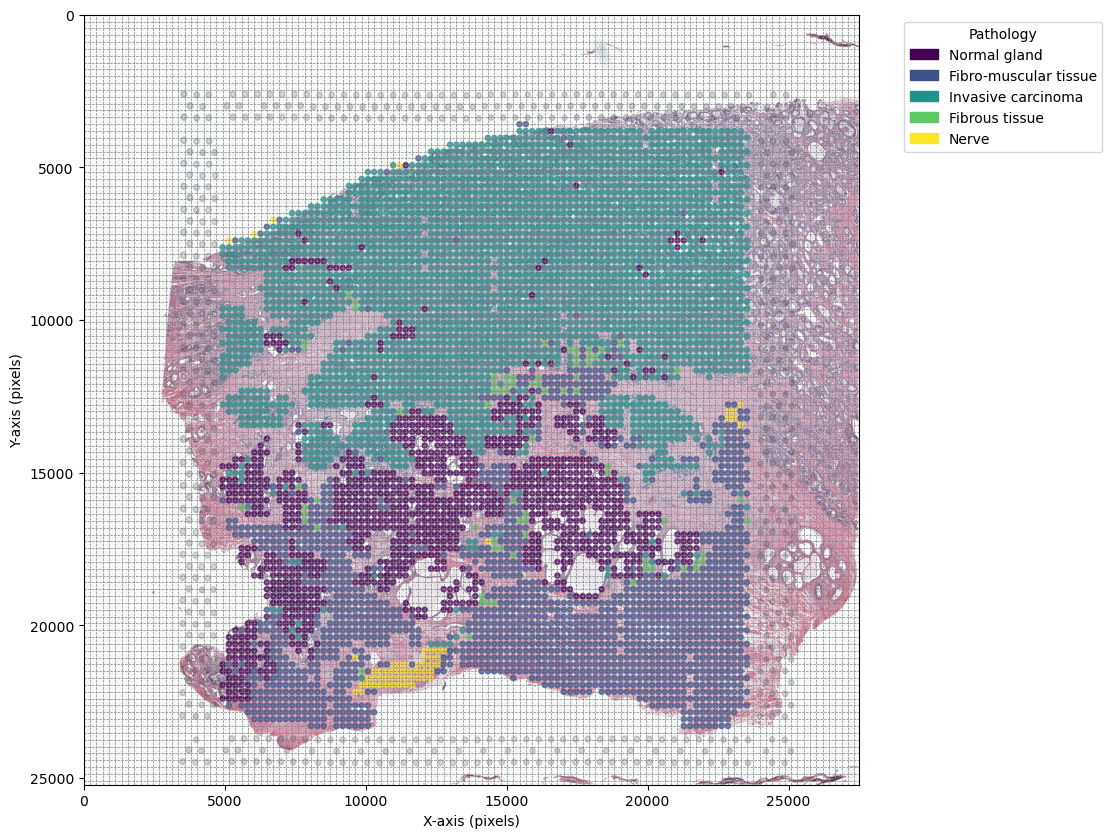

In [51]:


image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples_color_labels(image_path, df_predicted_dnn, 27482, 25219)